# LLM-based synthetic data generation

The goal of this notebook is to explain how to use LLMs for synthetic
data generation, especially in the context of statistical
classifications. This is an important step towards training a
classifier, since it helps to mitigate some problems with real-world
data like scarcity, mislabelling and data gaps. Moreover, as we will
see, this strategy allows us to significantly improve the performance of
classifiers using few resources. An implementation of a full pipeline,
together with documentation and a jupyter notebook tutorial, can be seen
in https://github.com/AIML4OS/WP10_Cluster1_StatCodGen#

In [1]:
#!pip install openai

In [2]:
import pandas as pd
import openai #for LLMs calls

## 1. Why do we need synthetic data?

Real-world data for training classifiers for statistical classifications
have several issues: - Statistical classifications are very complex and
have lots of nuances and caveats, so it is not always clear how to
classify a given text. - Sometimes data is annotated by non-experts,
which lead to mistakes. - Some texts are ambiguous, meaning that there
is not enough information to reliably classify them in one class. - Some
classes are hugely underrepresented in real-world data (by the structure
of the economy), so it can be difficult to obtain enough samples for
that data.

Moreover, obtaining more real-world data is usually a very
resource-expensive task. However, nowadays we have at our disposal the
generative capabilities of LLMs, which produce text which is nearly
indistinguishable from human-produced text. We can exploit this to
generate as many real-looking samples as we want very quickly and in a
completely automated way.

Empirically it has been observed that mixing real-world data with
good-quality synthetic data improves substantially the accuracy of the
classification models.

## 2. Reading the data

### 2.1 Sample data

Here we read the real-world sample data available to train the model and
do some easy explanatory analysis to check class coverage.

In [3]:
df = pd.read_parquet(
    "https://minio.lab.sspcloud.fr/projet-formation/diffusion/mlops/data/firm_activity_data.parquet"
)
df.head()

In [4]:
nace_2digit_to_section = {
    # Section A: Agriculture, forestry and fishing
    "01": "A", "02": "A", "03": "A",

    # Section B: Mining and quarrying
    "05": "B", "06": "B", "07": "B", "08": "B", "09": "B",

    # Section C: Manufacturing
    "10": "C", "11": "C", "12": "C", "13": "C", "14": "C",
    "15": "C", "16": "C", "17": "C", "18": "C", "19": "C",
    "20": "C", "21": "C", "22": "C", "23": "C", "24": "C",
    "25": "C", "26": "C", "27": "C", "28": "C", "29": "C",
    "30": "C", "31": "C", "32": "C", "33": "C",

    # Section D: Electricity, gas, steam and air conditioning supply
    "35": "D",

    # Section E: Water supply; sewerage, waste management and remediation
    "36": "E", "37": "E", "38": "E", "39": "E",

    # Section F: Construction
    "41": "F", "42": "F", "43": "F",

    # Section G: Wholesale and retail trade
    "45": "G", "46": "G", "47": "G",

    # Section H: Transportation and storage
    "49": "H", "50": "H", "51": "H", "52": "H", "53": "H",

    # Section I: Accommodation and food service activities
    "55": "I", "56": "I",

    # Section J: Information and communication
    "58": "J", "59": "J", "60": "J", "61": "J", "62": "J", "63": "J",

    # Section K: Financial and insurance activities
    "64": "K", "65": "K", "66": "K",

    # Section L: Real estate activities
    "68": "L",

    # Section M: Professional, scientific and technical activities
    "69": "M", "70": "M", "71": "M", "72": "M", "73": "M", "74": "M", "75": "M",

    # Section N: Administrative and support service activities
    "77": "N", "78": "N", "79": "N", "80": "N", "81": "N", "82": "N",

    # Section O: Public administration and defence
    "84": "O",

    # Section P: Education
    "85": "P",

    # Section Q: Human health and social work activities
    "86": "Q", "87": "Q", "88": "Q",

    # Section R: Arts, entertainment and recreation
    "90": "R", "91": "R", "92": "R", "93": "R",

    # Section S: Other service activities
    "94": "S", "95": "S", "96": "S",

    # Section T: Activities of households as employers
    "97": "T", "98": "T",

    # Section U: Activities of extraterritorial organizations
    "99": "U"
}

In [5]:
df['label'] = df['nace'].apply(lambda x: x[:2]).map(nace_2digit_to_section)
df.head()

In [6]:
# Add all possible labels
all_labels = sorted(list(set(nace_2digit_to_section.values())))
all_labels # From A to U

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U']

In [7]:
df['label'] = pd.Categorical(df['label'], categories = all_labels)
df['label'].value_counts()

label
G    122216
M    103344
I     93743
L     92525
F     61098
S     60125
H     50241
N     48516
Q     40265
J     32783
C     28091
R     26212
K     25289
P     25269
A     22429
D     12550
E      1655
O       161
B       129
U        11
T         0
Name: count, dtype: int64

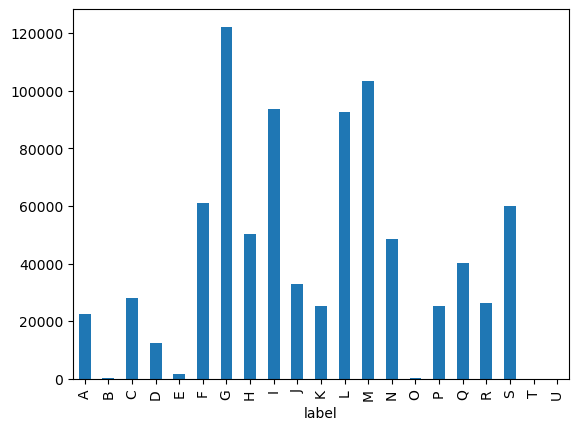

In [8]:
df['label'].value_counts().sort_index().plot(kind='bar')

We see that some sections, particularly O, B and U have very few
training samples. Moreover there are no samples for section T. We are
going to generate samples for these sections. To obtain the best
results, it is important to generate samples at the most disaggregated
level (class) and then aggregate them to the desired level. In this way
we can leverage all the information contained in the explanatory notes.

### 2.2 Explanatory notes

We will use the information in the explanatory notes of the statistical
classification (NACE in this case) in order to provide the necessary
information to the LLM to generate new samples. Explanatory notes
contain a lot of high-quality information for each class of the
statistical classifcation. Typically the information provided consists
of: - **Code of the class** - **Title of the class** - **Includes:** a
description of activities included in this class. - **Also includes:** a
description of some activities which are also included in this class. -
**Not includes:** a description of some activities which are not
included in the class, but are related to activities which are included.

In order to use the information contained in the explanatory notes in an
easy way it is convenient to prepare them in a machine-readable format,
following the above categories. This can be done in formats like XML or
JSON, or simply in an excel or csv file. In this case we have prepared
an excel file with the information contained in the NAF notes. At
Statistics Spain we provide an excel file with this information
(https://www.ine.es/daco/daco42/clasificaciones/cnae25/notas_explicativas_CNAE_2025.xlsx)

In [9]:
NAFnotes = pd.read_excel("NAFclasses.xlsx", keep_default_na=False)
NAFnotes.head()

## 3. Generation of synthetic data

Our strategy is based on the paper ZeroGen
(https://arxiv.org/abs/2202.07922). The idea is simple but extremely
powerful: we leverage the generative abilities of LLMs to generate
plausible samples (similar to real-world samples) for generating
synthetic samples from the high-quality information contained in the
explanatory notes.

We want to generate synthetic samples following two fundamental
principles: - **Faithfulness:** the generated samples should be
correctly coded and should be relevant to the problem at hand. -
**Diversity:** the generated samples should display enough variety, both
in style and content.

In this section, we will first explain how to setup an LLM API to make
calls via Python, and then show how we can implement a simple data
generation strategy using LLMs in an automated way. In order to generate
faithful samples for each class, we need to provide the LLM with precise
information, which we take from the class description in the explanatory
notes. Even though in this tutorial we will develop classifiers at the
section level, we will generate samples at the most disaggregated level.
In general, even if we are interested in classifying at an aggregated
level, it is useful to generate always the samples at the most
disaggregated level, and later aggregate, in order to take full
advantage of the explanatory notes and to get the maximum possible
diversity of samples.

### 3.1 Setting up the LLM API

First, we show how to set up an LLM API. There are essentially two ways
to use an LLM: locally or remotely. Both have advantages and
disadvantages: - Local LLMs: uses an LLM which is directly run in our
computer (or the organization servers). Using an LLM locally allow us to
have complete control over the LLM and avoids cost and security
concerns. However, our organization needs the adequate hardware (GPUs),
especially for the larger models. We are limited to use only open-source
models (excluding e.g. most of OpenAI models). Setting up the LLM for
local use involves some extra steps before we can access it via an API.
Fortunately, nowadays there is software which makes this step very easy,
like Ollama or vLLM. - Remote LLMs: uses an LLM which runs in remote
servers, typically in the premises of the provider of the model (OpenAI,
Meta, Microsoft, …). The advantages are that they are easier to set up
and use, allow us to run very large models without having to care about
computing resources, and allow us to run closed-source models like most
of OpenAI models. The disadvantages are the costs (each API call costs a
quantity of money), security concerns, and less control over the models
(they can update a model or discontinue it).

In this tutorial we will use for simplicity a remote provider, **Groq**
(do not confuse with Grok, the family of xAI models), which has the
advantage of allowing some free tokens and which is the provider we have
used at Statistics Spain.

Groq uses the OpenAI API to make the calls to the LLMs. Therefore, we
must make sure we include the line: `import openai` in our code. The
next step is to log in (or create an account) at the Groq website:
https://groq.com/ , go to “API Keys” and click on “Create API key”.
After introducing a name the key will be created. We must copy the key
and put it in a python variable:

In [10]:
API_KEY='<INSERT_API_KEY_HERE>'

Now to set up the client we execute the next chunk of code:

In [11]:
# Preparing Groq API
client = openai.OpenAI(
    api_key=API_KEY,
    base_url="https://api.groq.com/openai/v1"
)

We now can use the models provided by Groq. To do it we use the next
code, giving it a prompt:

In [12]:
# Groq call
response = client.responses.create(
    model="llama-3.3-70b-versatile", # model we want to use
    input="Hi! How are you?",        # prompt
)

It returns us a Response object, which contains all the information of
the LLM call. Here we will only be interested in the output of the
model, which can be accessed as follows:

In [13]:
response.output_text

"Hello. I'm doing well, thanks for asking. I'm a large language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to assist you with any questions or tasks you may have. How about you? How's your day going?"

### 3.2 Data generation from the explanatory notes

We use the explanatory notes of the statistical classification in order
to generate new samples. Since the explanatory notes are a high-quality
source, we expect that there are few mislabelled samples in the
generated samples. Indeed, empirically it has been verified that the
synthetic data generated in this way generally contains much less
mistakes than real-world data.

Our strategy for data generation will consist in constructing a generic
prompt, which can be easily adapted to each class, that includes the
title of the class and the relevant information from the explanatory
notes, and then pass this prompt to an LLM which will generate the
desired number of samples.

In order to obtain the best possible results it is important to
construct the prompt carefully. While this is a highly empirical task,
there are some guidelines which have proven to be universally useful
(see, for instance, Section 3.1 of https://arxiv.org/abs/2406.15126v1).
A well-constructed prompt should consist of the following parts: -
**Task specification:** A description of the task the LLM must fulfill.
A prologue to set the scene, such as “You are an expert in training data
generation for classification models” often improves performance. -
**Conditions:** The conditions and instructions the LLM must follow in
the generation task. - **In-context examples:** Examples of the expected
output. This has been observed to provide a huge performance
improvement.

In [14]:
def generate_prompt(root, text, number):
    prompt_process_notes = (
                "Vous êtes un expert en génération de données d'entraînement pour les modèles de classification.\n "
                 "Votre tâche consiste à prendre une phrase racine d'une activité économique générale et à générer des phrases d'entraînement à partir d'exemples concrets inclus dans un texte.\n "
                 "Le cas échéant, essayez d'introduire le mot 'autre' ou 'autre' ainsi que l'utilisation ou la destination du produit.\n "
                 "Chaque fois qu'un objet est fabriqué, incluez le matériau à partir duquel il est fait.\n "
                 "Évitez de produire des phrases complètement différentes ou changeant de contexte et ne retournez QUE des phrases sans introduction, commentaire, explication ou phrase supplémentaire.\n "
                 "Évitez d'introduire vos résultats par des phrases telles que 'voici les phrases générées' ou similaires.\n "
                 "Écrivez chaque phrase sur une ligne séparée.\n "
                 "Écrivez tout en majuscules.\n "
                 "Ne mets pas de point à la fin de la phrase.\n "
                 "Je veux utiliser votre résultat directement, donc je veux UNIQUEMENT les phrases.\n "
                 "Voici un exemple :\n "
                 "Racine : Production de produits de boulangerie et de confiserie.\n "
                 "Texte : Cette classe comprend la fabrication de tous les produits de boulangerie tels que : pains, gâteaux, autres farines et pains destinés à l'alimentation animale.\n "
                 "Sortie :\n "
                 "FABRICATION DE MICHES DE PAIN\n "
                 "PRODUCTION DE PAIN POUR ANIMAUX\n "
                 "PRODUCTION DE GÂTEAUX\n "
                 "PRODUCTION D'AUTRES FARINES\n "
                f"Maintenant vous le faites avec la racine et le texte suivants, en générant {number} phrases:\n "
                f"Racine: {root}.\n "
                f"Texte: {text}."
            )
    return prompt_process_notes

First we see how it works in one specific case, step by step. We will
use subclass 25.11Y.

In [15]:
prompt = generate_prompt("Fabrication de structures métalliques et de parties de structures", 
                         """Cette sous-classe comprend :
                            - la fabrication de cadres métalliques ou d’ossatures pour la construction et de leurs éléments 
                            (tours, pylônes en treillis, armatures, ponts, éléments de ponts, etc.)
                            - la fabrication de matériel d'échafaudage, de coffrage ou d'étayage
                            - la fabrication de cadres métalliques pour équipements industriels (cadres pour hauts fourneaux, 
                            matériels de manutention, etc.)
                            - la fabrication de constructions préfabriquées principalement en métaux :
                            • baraques de chantier, éléments modulaires pour expositions, etc.
                            """, 
                         10)
print(prompt)

Vous êtes un expert en génération de données d'entraînement pour les modèles de classification.
 Votre tâche consiste à prendre une phrase racine d'une activité économique générale et à générer des phrases d'entraînement à partir d'exemples concrets inclus dans un texte.
 Le cas échéant, essayez d'introduire le mot 'autre' ou 'autre' ainsi que l'utilisation ou la destination du produit.
 Chaque fois qu'un objet est fabriqué, incluez le matériau à partir duquel il est fait.
 Évitez de produire des phrases complètement différentes ou changeant de contexte et ne retournez QUE des phrases sans introduction, commentaire, explication ou phrase supplémentaire.
 Évitez d'introduire vos résultats par des phrases telles que 'voici les phrases générées' ou similaires.
 Écrivez chaque phrase sur une ligne séparée.
 Écrivez tout en majuscules.
 Ne mets pas de point à la fin de la phrase.
 Je veux utiliser votre résultat directement, donc je veux UNIQUEMENT les phrases.
 Voici un exemple :
 Racine :

In [16]:
# Groq call
response = client.responses.create(
    model="llama-3.3-70b-versatile",
    input=prompt,
)

In [17]:
response.output_text.split('\n')

['FABRICATION DE CADRES MÉTALLIQUES POUR CONSTRUCTION',
 'FABRICATION DE TOURS EN MÉTAUX POUR SUPPORT',
 "FABRICATION DE PYLÔNES EN TREILLIS POUR DISTRIBUTION D'ÉNERGIE",
 'FABRICATION DE PONT EN MÉTAUX DESTINÉ À LA CIRCULATION',
 "FABRICATION DE MATÉRIEL D'ÉCHAFAUDAGE EN MÉTAUX POUR CONSTRUCTION",
 'FABRICATION DE COFFRAGE EN MÉTAUX POUR BÉTONNAGE',
 'FABRICATION DE CADRES MÉTALLIQUES POUR ÉQUIPEMENTS INDUSTRIELS',
 'FABRICATION DE BARAQUES DE CHANTIER EN MÉTAUX POUR STOCKAGE',
 "FABRICATION D'ÉLÉMENTS MODULAIRES EN MÉTAUX POUR EXPOSITION",
 'FABRICATION DE STRUCTURES PRÉFABRIQUÉES EN MÉTAUX POUR CONSTRUCTION']

Now we can prepare, following the same steps, a general function that
generates samples for a given class in an automatic fashion:

In [18]:
def generate_samples(NAFclass, num_samples, notes = NAFnotes):
    class_notes = NAFnotes[NAFnotes['Code']== NAFclass].iloc[0]
    # 1. Generate the prompt
    if class_notes['Includes']:
        prompt = generate_prompt(class_notes['Title'], class_notes['Includes'], num_samples)
    else: # If includes section is empty
        prompt = generate_prompt(class_notes['Title'], class_notes['Title'], num_samples)
    
    # 2. Generate samples by calling Groq API
    response = client.responses.create(
                model="llama-3.3-70b-versatile",
                input=prompt,
                )
    samples = response.output_text.split('\n')
    return pd.DataFrame({'text':samples, 'class':NAFclass})

In [19]:
NAFclass = '25.11Y'
generate_samples(NAFclass, 10, notes = NAFnotes)

Finally, we can generate a function for generating synthetic samples for
a given section. The strategy is to generate some examples for each of
the classes contained in the section using our previous function, and
the put everything together.

In [20]:
def generate_samples_section(section, num_samples, notes = NAFnotes):
    samples_df = pd.DataFrame()
    classes = notes[notes['Section'] == section]['Code'] # Select classes of the given section from the notes
    num_classes = len(classes) # Number of classes in the given section
    
    # For each class generate samples and concatenate with the samples already generated. 
    # We generate int(num_samples/num_classes)+1 samples for each class in the section,
    # so in total we get approx num_samples for the section.
    for NAFclass in classes:
        samples_df = pd.concat([samples_df, generate_samples(NAFclass, int(num_samples/num_classes)+1, notes)]) 
        
    samples_df['label']=section # Add the section as label
    
    return samples_df

In [21]:
samplesT = generate_samples_section('T', 50)

In [22]:
samplesT.head()

Here we will generate 200 samples for each of the four less represented
sections (B, O, T, U). We can do it in the following way:

In [23]:
synthetic_df = pd.concat([generate_samples_section(section, 200) for section in ['O','B','U','T']])

In [24]:
synthetic_df

2462 rows × 3 columns

In [26]:
synthetic_df = synthetic_df.drop(columns=['class'])

In [27]:
synthetic_df.to_csv("synthetic_df.csv", index=False)

### 3.3 Some ideas for further improvement

We have seen an example of a basic generation strategy. However, there
is plenty of research to be done in this direction, and there are lots
of experiments one can perform. Here we just give some ideas or
suggestions that one could try: - Prompt engineering. Try different
prompt structures or variations. Try giving examples for each class
instead of using the same generic example for all classes. - Improve
diversity of samples by asking an LLM to generate it in different styles
(longer, shorter, with ortographical errors, etc). - Improve further the
diversity by asking several distinct LLMs to produce samples. - Use not
just the “Includes” section of the explanatory notes, but also the “Also
includes” and the “Not included” section. - Exploit the hierarchical
structure of the classification in the prompt, giving not only
information about the class but also the higher groups. - Data curation:
improve the quality of the generated samples by including a process of
filtering (by humans or by another LLM). - Evaluation of the synthetic
dataset: both direct (measuring the quality of the data generated) and
indirect (evaluation of the classifiers trained/fine-tuned with the
synthetic data).